# Load data

In [1]:
import cv2
import numpy as np
import os

def extract_frames_and_optical_flow(video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()

    if not ret:
        print("Failed to read the video.")
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        prev_gray = gray

        frame_path = os.path.join(output_dir, f'frame_{frame_idx:04d}.png')
        flow_path = os.path.join(output_dir, f'flow_{frame_idx:04d}.npy')
        
        cv2.imwrite(frame_path, frame)
        np.save(flow_path, flow)

        frame_idx += 1

    cap.release()
    print(f"Extracted {frame_idx} frames and optical flow.")

video_path = 'output_video.mp4'
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)
extract_frames_and_optical_flow(video_path, output_dir)


Extracted 71 frames and optical flow.


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FrameOpticalFlowDataset(Dataset):
    def __init__(self, frame_dir, flow_dir, transform=None):
        self.frame_dir = frame_dir
        self.flow_dir = flow_dir
        self.transform = transform
        self.frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.png')])
        self.flow_files = sorted([f for f in os.listdir(flow_dir) if f.endswith('.npy')])

    def __len__(self):
        return len(self.frame_files) - 1

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frame_dir, self.frame_files[idx])
        next_frame_path = os.path.join(self.frame_dir, self.frame_files[idx + 1])
        flow_path = os.path.join(self.flow_dir, self.flow_files[idx])

        frame = cv2.imread(frame_path)
        next_frame = cv2.imread(next_frame_path)
        flow = np.load(flow_path)

        if self.transform:
            frame = self.transform(frame)
            next_frame = self.transform(next_frame)

        flow = torch.from_numpy(flow).permute(2, 0, 1).float()  # Convert to (C, H, W)

        return frame, flow, next_frame

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = FrameOpticalFlowDataset('./output', './output', transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


# Build model

In [7]:
import torch
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self, cnn_out_channels, lstm_hidden_size, lstm_num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.lstm = nn.LSTM(input_size=128 * 16 * 16, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)
        
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        
    def forward(self, frames, optical_flows):
        # Concatenate frames and optical flow
        x = torch.cat((frames, optical_flows), dim=1)
        
        # Extract features using CNN
        cnn_out = self.cnn(x)
        
        # Flatten the CNN output
        cnn_out = cnn_out.view(cnn_out.size(0), -1)
        
        # Prepare input for LSTM
        cnn_out = cnn_out.unsqueeze(1)  # Add sequence dimension
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(cnn_out)
        
        # Output layer
        output = self.fc(lstm_out[:, -1, :])
        
        return output

# Hyperparameters
learning_rate = 0.001
num_epochs = 100
batch_size = 8
cnn_out_channels = 128
lstm_hidden_size = 256
lstm_num_layers = 2
output_size = 3 * 128 * 128  # Example output size for 128x128 RGB frames

# Instantiate model, loss function, and optimizer
model = CNNLSTM(cnn_out_channels, lstm_hidden_size, lstm_num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Device setup
check_gpu = None
if torch.cuda.is_available():
    check_gpu = 'cuda'
elif torch.backends.mps.is_available():
    check_gpu = 'mps'
else:
    check_gpu = 'cpu'
device = torch.device(check_gpu)
model.to(device)


CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(32768, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=49152, bias=True)
)

# Train model

In [10]:
for epoch in range(num_epochs):
    for i, (frames, optical_flows, next_frames) in enumerate(dataloader):
        frames = frames.to(device)
        optical_flows = optical_flows.to(device)
        next_frames = next_frames.to(device).view(next_frames.size(0), -1)  # Flatten next frames
        
        # Forward pass
        outputs = model(frames, optical_flows)
        loss = criterion(outputs, next_frames)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/100], Step [1/9], Loss: 0.0434
Epoch [1/100], Step [2/9], Loss: 0.0343
Epoch [1/100], Step [3/9], Loss: 0.0431
Epoch [1/100], Step [4/9], Loss: 0.0642
Epoch [1/100], Step [5/9], Loss: 0.0370
Epoch [1/100], Step [6/9], Loss: 0.0406
Epoch [1/100], Step [7/9], Loss: 0.0412
Epoch [1/100], Step [8/9], Loss: 0.0441
Epoch [1/100], Step [9/9], Loss: 0.0621
Epoch [2/100], Step [1/9], Loss: 0.0543
Epoch [2/100], Step [2/9], Loss: 0.0527
Epoch [2/100], Step [3/9], Loss: 0.0557
Epoch [2/100], Step [4/9], Loss: 0.0594
Epoch [2/100], Step [5/9], Loss: 0.0831
Epoch [2/100], Step [6/9], Loss: 0.0324
Epoch [2/100], Step [7/9], Loss: 0.0381
Epoch [2/100], Step [8/9], Loss: 0.0378
Epoch [2/100], Step [9/9], Loss: 0.0375
Epoch [3/100], Step [1/9], Loss: 0.0335
Epoch [3/100], Step [2/9], Loss: 0.0550
Epoch [3/100], Step [3/9], Loss: 0.0442
Epoch [3/100], Step [4/9], Loss: 0.0415
Epoch [3/100], Step [5/9], Loss: 0.0656
Epoch [3/100], Step [6/9], Loss: 0.0453
Epoch [3/100], Step [7/9], Loss: 0.0302


# Evaluate

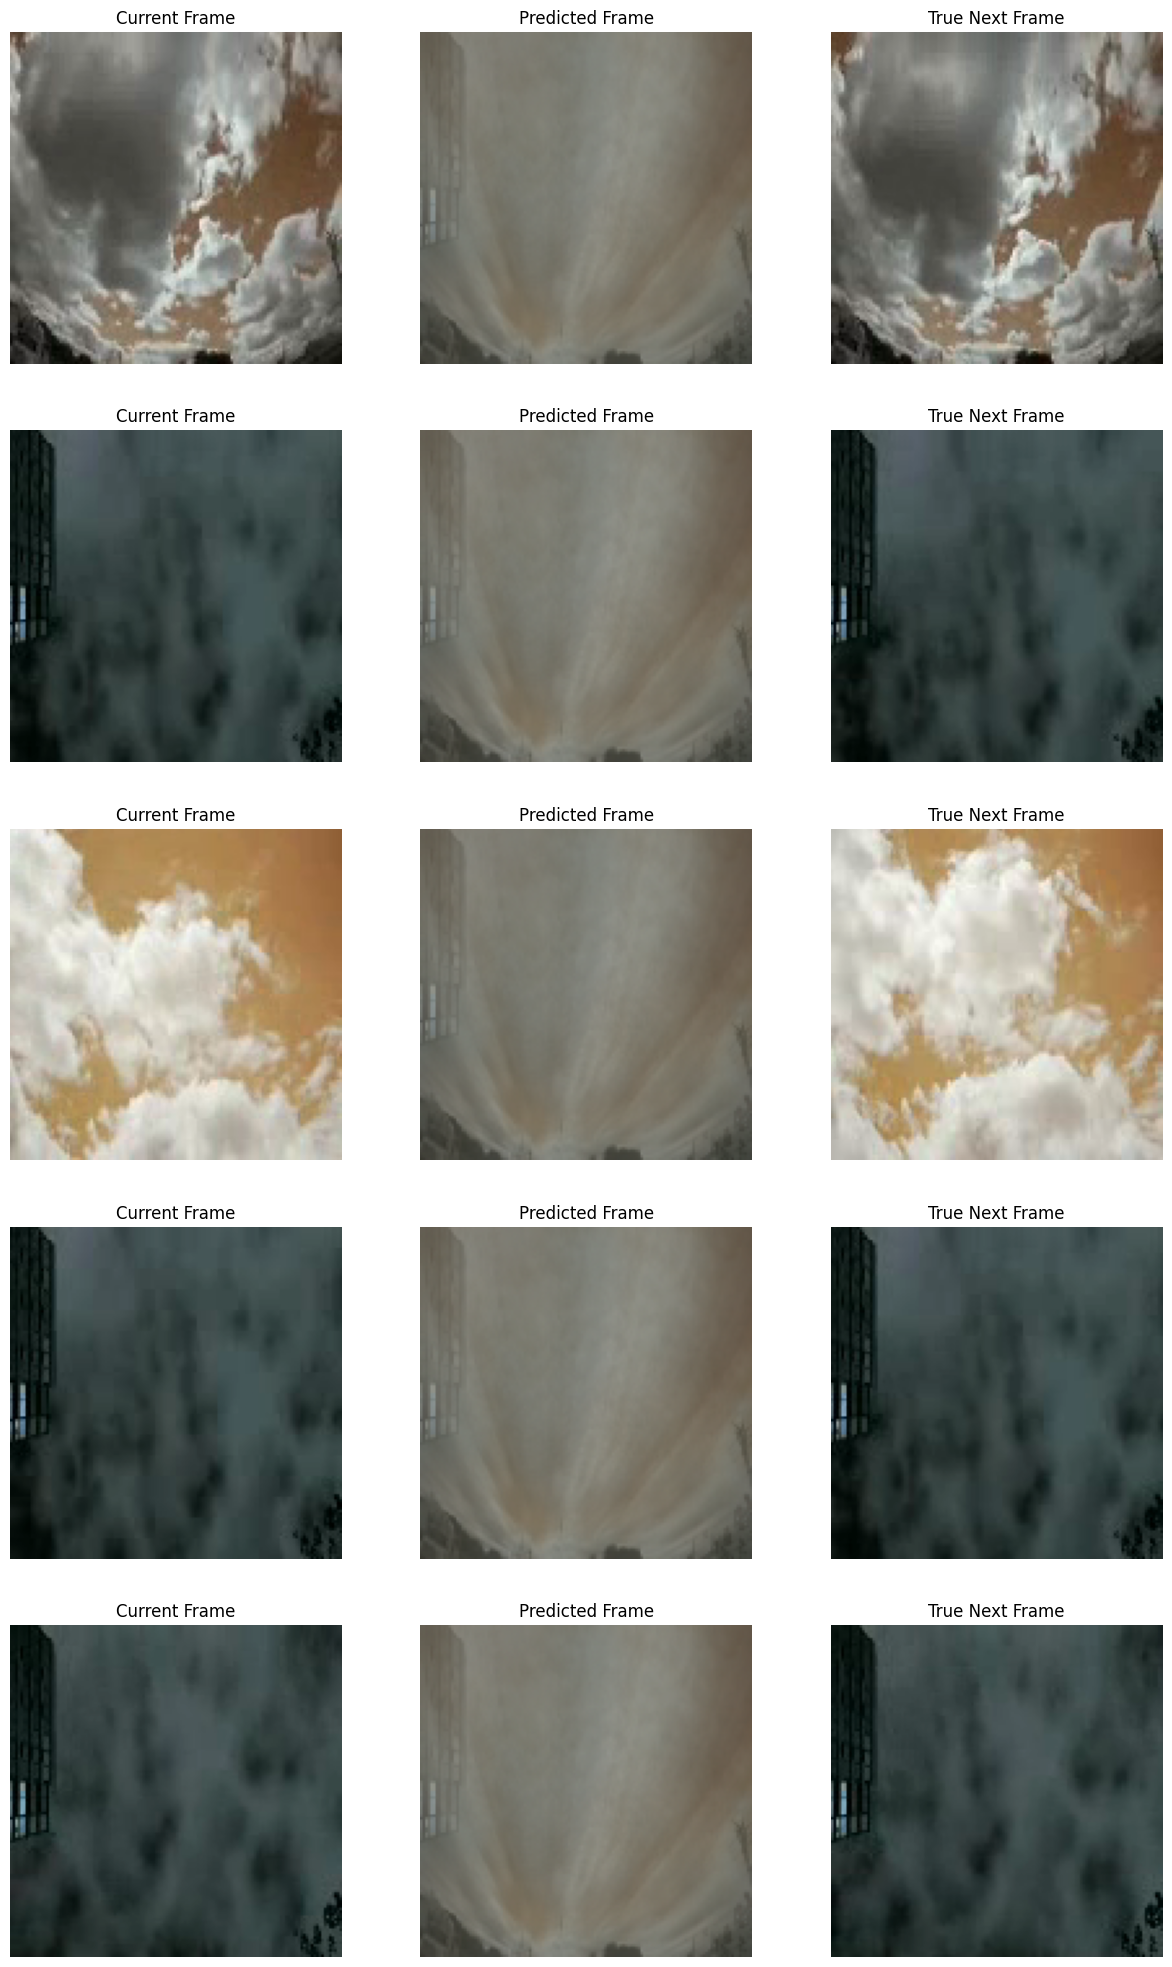

In [11]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, dataloader, device, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for i, (frames, optical_flows, next_frames) in enumerate(dataloader):
            frames = frames.to(device)
            optical_flows = optical_flows.to(device)
            next_frames = next_frames.to(device)
            
            # Forward pass
            outputs = model(frames, optical_flows)
            outputs = outputs.view(outputs.size(0), 3, 128, 128)  # Reshape to (N, C, H, W)
            
            # Move data back to CPU for plotting
            frames = frames.cpu()
            outputs = outputs.cpu()
            next_frames = next_frames.cpu()
            
            # Plotting
            fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
            
            for j in range(num_samples):
                current_frame = frames[j].permute(1, 2, 0).numpy()
                predicted_frame = outputs[j].permute(1, 2, 0).numpy()
                true_next_frame = next_frames[j].permute(1, 2, 0).numpy()
                
                axes[j, 0].imshow(current_frame)
                axes[j, 0].set_title('Current Frame')
                axes[j, 0].axis('off')
                
                axes[j, 1].imshow(predicted_frame)
                axes[j, 1].set_title('Predicted Frame')
                axes[j, 1].axis('off')
                
                axes[j, 2].imshow(true_next_frame)
                axes[j, 2].set_title('True Next Frame')
                axes[j, 2].axis('off')
            
            plt.show()
            
            # Break after plotting the required number of samples
            if (i + 1) * dataloader.batch_size >= num_samples:
                break

# Evaluate and plot results
evaluate_and_plot(model, dataloader, device, num_samples=5)
